# Introduction to Vertex Pipelines



## Learning Objectives

1. Use the Kubeflow Pipelines SDK to build scalable ML pipelines

2. Create and run a 3-step intro pipeline that takes text input

3. Create and run a pipeline that trains, evaluates, and deploys an AutoML classification model

4. Use pre-built components for interacting with Vertex AI services, provided through the google_cloud_pipeline_components library

5. Schedule a pipeline job with Cloud Scheduler



## Introduction 

In this notebook, you will learn how to create and run ML pipelines with Vertex Pipelines.


Each learning objective will correspond to a __#TODO__ in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/vertex_ai/labs/intro-to-vertex-pipelines.ipynb) -- try to complete that notebook first before reviewing this solution notebook. 






# Vertex Pipelines setup

There are a few additional libraries we'll need to install in order to use Vertex Pipelines:

* **Kubeflow Pipelines**: This is the SDK we'll be using to build our pipeline. Vertex Pipelines supports running pipelines built with both Kubeflow Pipelines or TFX.

* **Google Cloud Pipeline Components**: This library provides pre-built components that make it easier to interact with Vertex AI services from your pipeline steps.


### Step 1: Install necessary libraries

To install both services we'll be using in this lab, first set the user flag in a notebook cell:

In [ ]:
USER_FLAG = "--user"

Then run the following from your notebook:

In [ ]:
!pip3 install {USER_FLAG} google-cloud-aiplatform==1.0.0 --upgrade
!pip3 install {USER_FLAG} kfp google-cloud-pipeline-components==0.1.1 --upgrade

     |████████████████████████████████| 1.8 MB 27.8 MB/s 
     |████████████████████████████████| 105 kB 42.3 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 105 kB 57.7 MB/s 
     |████████████████████████████████| 104 kB 62.5 MB/s 
     |████████████████████████████████| 104 kB 62.8 MB/s 
     |████████████████████████████████| 103 kB 64.4 MB/s 
     |████████████████████████████████| 103 kB 61.9 MB/s 
     |████████████████████████████████| 103 kB 60.0 MB/s 
     |████████████████████████████████| 103 kB 61.3 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
     |████████████████████████████████| 97 kB 5.8 MB/s 
     |████████████████████████████████| 96 kB 4.5 MB/s 
     |████████████████████████████████| 96 kB 5.4 MB/s 
     |████████████████████████████████| 96 kB 5.3 MB/s 
     |████████████████████████████████| 92 kB 10.2 MB/s 
     |███████████████████████

     |████████████████████████████████| 231 kB 32.9 MB/s 
     |████████████████████████████████| 127 kB 54.1 MB/s 
     |████████████████████████████████| 636 kB 31.7 MB/s 
     |████████████████████████████████| 1.7 MB 32.0 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 87 kB 7.0 MB/s 
     |████████████████████████████████| 52 kB 404 kB/s 
  Created wheel for kfp: filename=kfp-1.7.0-py3-none-any.whl size=320984 sha256=414177b973c92eabf78b7591bb9e01e10d06f5d18b89c7b26941001297fd7f25
  Stored in directory: /root/.cache/pip/wheels/2c/4e/8e/7c38c0cefe4701caf621009fe1b44d07c0a4e2caba3856b288
  Created wheel for docstring-parser: filename=docstring_parser-0.10-py3-none-any.whl size=28862 sha256=3fb48f

After installing these packages you'll need to restart the kernel:

In [ ]:
import os
if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Finally, check that you have correctly installed the packages. **The KFP SDK version should be >=1.6**:

In [ ]:
!python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"
!python3 -c "import google_cloud_pipeline_components; print('google_cloud_pipeline_components version: {}'.format(google_cloud_pipeline_components.__version__))"

KFP SDK version: 1.7.0
google_cloud_pipeline_components version: 0.1.1


### Step 2: Set your project ID and bucket

Throughout this lab you'll reference your Cloud project ID and the bucket you created earlier. Next we'll create variables for each of those.

If you don't know your project ID you may be able to get it by running the following:

In [ ]:
import os
PROJECT_ID = ""
# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  


Otherwise, set it here:

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "qwiklabs-gcp-04-75f7f02eedf5"  # @param {type:"string"}

Then create a variable to store your bucket name. If you created it in this lab, the following will work. Otherwise, you'll need to set this manually:

In [ ]:
BUCKET_NAME="gs://" + PROJECT_ID + "-bucket"

### Step 3: Import libraries

Add the following to import the *libraries* we'll be using throughout this lab:

In [ ]:
from typing import NamedTuple
import kfp
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, ClassificationMetrics, Metrics, component)
from kfp.v2.google.client import AIPlatformClient
from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip

### Step 4: Define constants

The last thing we need to do before building our pipeline is define some constant variables. PIPELINE_ROOT is the Cloud Storage path where the artifacts created by our pipeline will be written. We're using us-central1 as the region here, but if you used a different region when you created your bucket, update the REGION variable in the code below:

In [ ]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="us-central1"
PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"
PIPELINE_ROOT

env: PATH=/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin:/home/jupyter/.local/bin


'gs://qwiklabs-gcp-04-75f7f02eedf5-bucket/pipeline_root/'

After running the code above, you should see the root directory for your pipeline printed. This is the Cloud Storage location where the artifacts from your pipeline will be written. It will be in the format of gs://Your_Project_ID/pipeline_root/

# Creating your first pipeline

To get familiar with how Vertex Pipelines works, we'll first create a short pipeline using the KFP SDK. This pipeline doesn't do anything ML related (don't worry, we'll get there!), we're using it to teach you:

* How to create custom components in the KFP SDK
* How to run and monitor a pipeline in Vertex Pipelines

We'll create a pipeline that prints out a sentence using two outputs: a product name and an emoji description. This pipeline will consist of three components:

* **product_name**: This component will take a product name (or any noun you want really) as input, and return that string as output
* **emoji**: This component will take the text description of an emoji and convert it to an emoji. For example, the text code for ✨ is "sparkles". This component uses an emoji library to show you how to manage external dependencies in your pipeline
* **build_sentence**: This final component will consume the output of the previous two to build a sentence that uses the emoji. For example, the resulting output might be "Vertex Pipelines is ✨".

Let's start coding!

### Step 1: Create a Python function based component

Using the KFP SDK, we can create components based on Python functions. We'll use that for the 3 components in our first pipeline. We'll first build the **product_name** component, which simply takes a string as input and returns that string. Add the following to your notebook:

In [ ]:
@component(base_image="python:3.9", output_component_file="first-component.yaml")
def product_name(text: str) -> str:
    return text

Let's take a closer look at the syntax here:

* The @component decorator compiles this function to a component when the pipeline is run. You'll use this anytime you write a custom component.

* The base_image parameter specifies the container image this component will use.

* The output_component_file parameter is optional, and specifies the yaml file to write the compiled component to. After running the cell you should see that file written to your notebook instance. If you wanted to share this component with someone, you could send them the generated yaml file and have them load it with the following:



In [ ]:
product_name_component = kfp.components.load_component_from_file('./first-component.yaml')

* The -> str after the function definition specifies the output type for this component.

### Step 2: Create two additional components

To complete our pipeline, we'll create two more components. The first one we'll define takes a string as input, and converts this string to its corresponding emoji if there is one. It returns a tuple with the input text passed, and the resulting [emoji](https://pypi.org/project/emoji/):

In [ ]:
@component(packages_to_install=["emoji"])
def emoji(
    text: str,
) -> NamedTuple(
    "Outputs",
    [
        ("emoji_text", str),  # Return parameters
        ("emoji", str),
    ],
):
    import emoji
    emoji_text = text
    emoji_str = emoji.emojize(':' + emoji_text + ':', use_aliases=True)
    print("output one: {}; output_two: {}".format(emoji_text, emoji_str))
    return (emoji_text, emoji_str)

This component is a bit more complex than our previous one. Let's break down what's new:

* The packages_to_install paramater tells the component any external library dependencies for this container. In this case, we're using a library called emoji.
* This component returns a NamedTuple called Outputs. Notice that each of the strings in this tuple have keys: emoji_text and emoji. We'll use these in our next component to access the output.

The final component in this pipeline will consume the output of the first two and combine them to return a string:

In [ ]:
@component
def build_sentence(
    product: str,
    emoji: str,
    emojitext: str
) -> str:
    print("We completed the pipeline, hooray!")
    end_str = product + " is "
    if len(emoji) > 0:
        end_str += emoji
    else:
        end_str += emojitext
    return(end_str)

You might be wondering: how does this component know to use the output from the previous steps you defined? Good question! We will tie it all together in the next step.

### Step 3: Putting the components together into a pipeline

The component definitions we defined above created factory functions that can be used in a pipeline definition to create steps. To set up a pipeline, use the @dsl.pipeline decorator, give the pipeline a name and description, and provide the root path where your pipeline's artifacts should be written. By artifacts, we mean any output files generated by your pipeline. This intro pipeline doesn't generate any, but our next pipeline will.

In the next block of code we define an intro_pipeline function. This is where we specify the inputs to our initial pipeline steps, and how steps connect to each other:

* product_task takes a product name as input. Here we're passing "Vertex Pipelines" but you can change this to whatever you'd like.

* emoji_task takes the text code for an emoji as input. You can also change this to whatever you'd like. For example, "party_face" refers to the 🥳 emoji. Note that since both this and the product_task component don't have any steps that feed input into them, we manually specify the input for these when we define our pipeline.

* The last step in our pipeline - consumer_task has three input parameters:

* The output of product_task. Since this step only produces one output, we can reference it via product_task.output.

* The emoji output of our emoji_task step. See the emoji component defined above where we named the output parameters.

* Similarly, the emoji_text named output from the emoji component. In case our pipeline is passed text that doesn't correspond with an emoji, it'll use this text to construct a sentence.

In [ ]:
@dsl.pipeline(
    name="hello-world",
    description="An intro pipeline",
    pipeline_root=PIPELINE_ROOT,
)
# You can change the `text` and `emoji_str` parameters here to update the pipeline output
def intro_pipeline(text: str = "Vertex Pipelines", emoji_str: str = "sparkles"):
    product_task = product_name(text)
    emoji_task = emoji(emoji_str)
    consumer_task = build_sentence(
        product_task.output,
        emoji_task.outputs["emoji"],
        emoji_task.outputs["emoji_text"],
    )

### Step 4: Compile and run the pipeline

With your pipeline defined, you're ready to compile it. The following will generate a JSON file that you'll use to run the pipeline:

In [ ]:
compiler.Compiler().compile(
    pipeline_func=intro_pipeline, package_path="intro_pipeline_job.json"
)

Next, instantiate an API client:

In [ ]:
api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

Finally, run the pipeline:

In [ ]:
response = api_client.create_run_from_job_spec(
    job_spec_path="intro_pipeline_job.json",
    # pipeline_root=PIPELINE_ROOT  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
)

Running the pipeline should generate a link to view the pipeline run in your console. It should look like this when complete:

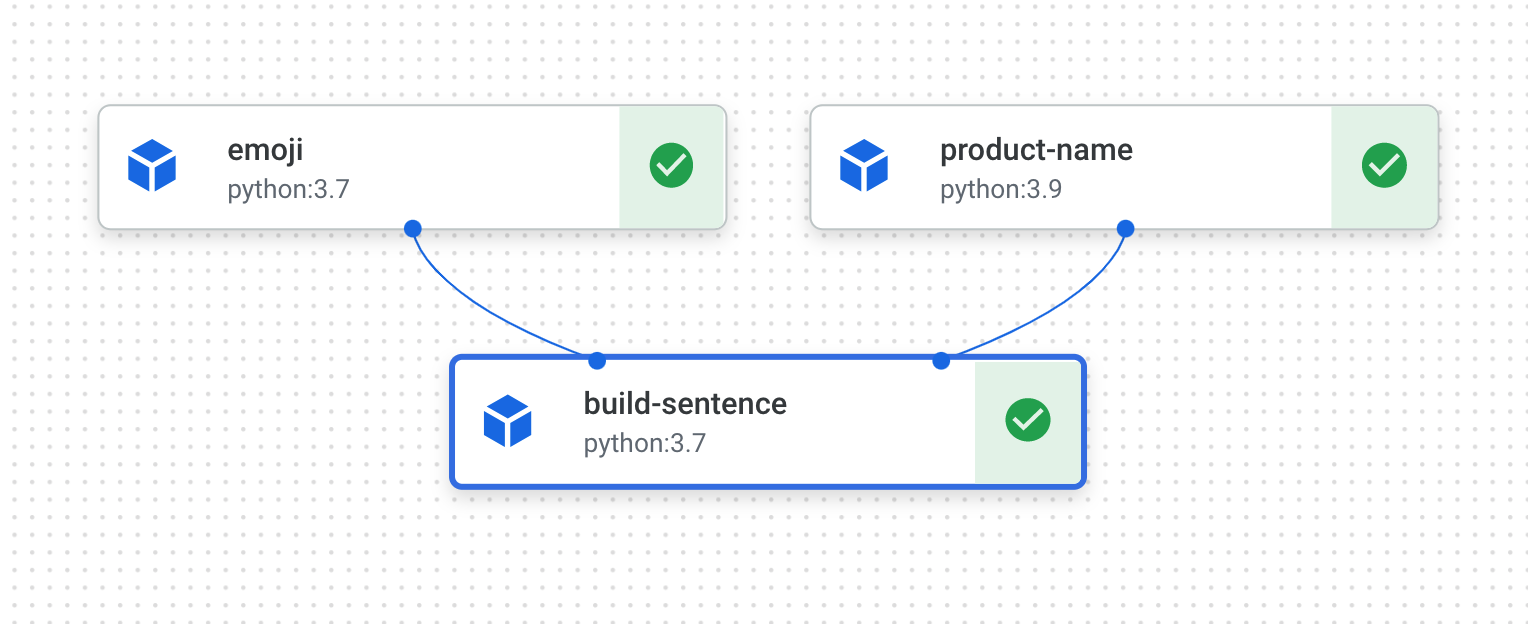

This pipeline will take **5-6 minutes** to run. When complete, you can click on the build-sentence component to see the final output:

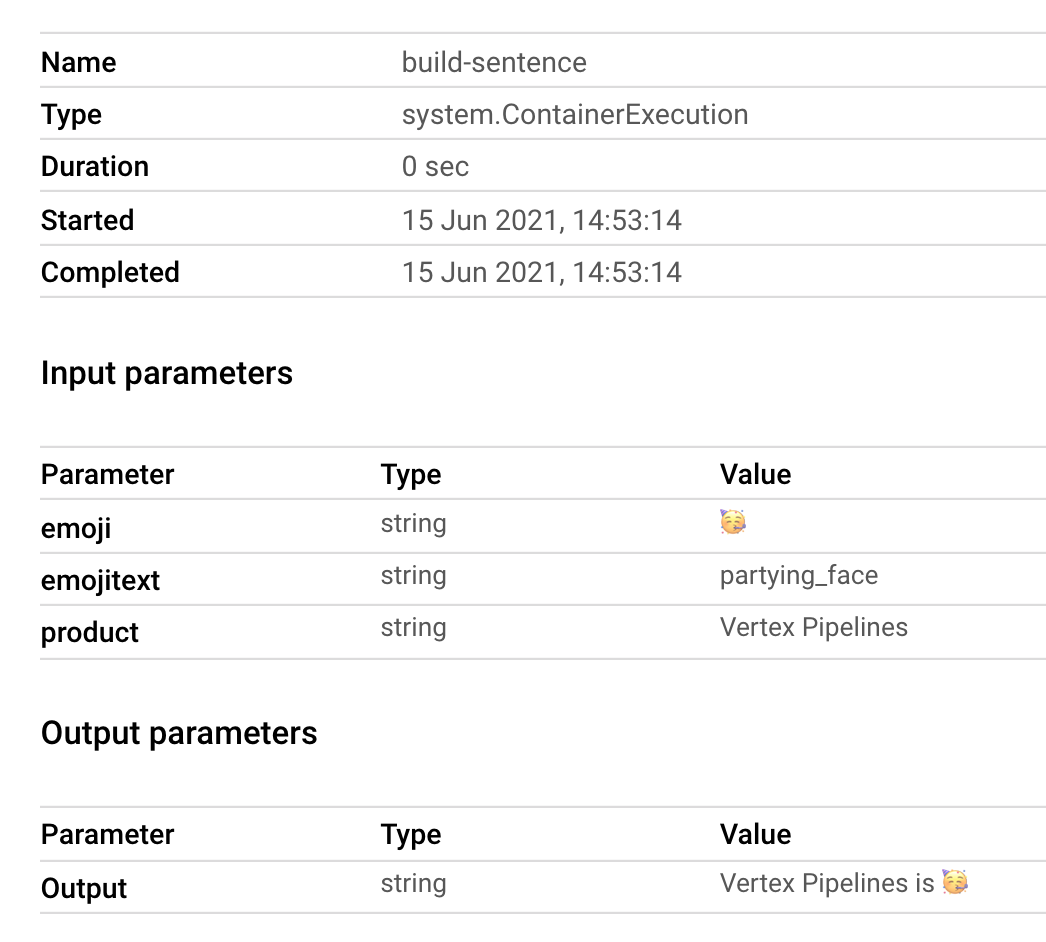

Now that you're familiar with how the KFP SDK and Vertex Pipelines works, you're ready to build a pipeline that creates and deploys an ML model using other Vertex AI services. Let's dive in!

# Creating an end-to-end ML pipeline

It's time to build your first ML pipeline. In this pipeline, we'll use the UCI Machine Learning [Dry beans dataset](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset), from: KOKLU, M. and OZKAN, I.A., (2020), "Multiclass Classification of Dry Beans Using Computer Vision and Machine Learning Techniques."In Computers and Electronics in Agriculture, 174, 105507. [DOI](https://www.sciencedirect.com/science/article/abs/pii/S0168169919311573?via%3Dihub).

This is a tabular dataset, and in our pipeline we'll use the dataset to train, evaluate, and deploy an AutoML model that classifies beans into one of 7 types based on their characteristics.

This pipeline will:

* Create a [Dataset](https://cloud.google.com/vertex-ai/docs/datasets/datasets) in Vertex AI
* Train a tabular classification model with [AutoML](https://cloud.google.com/vertex-ai/docs/training/automl-api)
* Get evaluation metrics on this model
* Based on the evaluation metrics, decide whether to deploy the model using conditional logic in Vertex Pipelines
* Deploy the model to an endpoint using [Vertex Prediction](https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api)

Each of the steps outlined will be a component. Most of the pipeline steps will use pre-built components for Vertex AI services via the [google_cloud_pipeline_components](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud) library we imported earlier in this lab. In this section, we'll define one custom component first. Then, we'll define the rest of the pipeline steps using pre-built components. Pre-built components make it easier to access Vertex AI services, like model training and deployment.

**The majority of time for this step is for the AutoML training piece of this pipeline, which will take about an hour.**

### Step 1: A custom component for model evaluation

The custom component we'll define will be used towards the end of our pipeline once model training has completed. This component will do a few things:

* Get the evaluation metrics from the trained AutoML classification model
* Parse the metrics and render them in the Vertex Pipelines UI
* Compare the metrics to a threshold to determine whether the model should be deployed

Before we define the component, let's understand its input and output parameters. As input, this pipeline takes some metadata on our Cloud project, the resulting trained model (we'll define this component later), the model's evaluation metrics, and a thresholds_dict_str. The thresholds_dict_str is something we'll define when we run our pipeline. In the case of this classification model, this will be the area under the ROC curve value for which we should deploy the model. For example, if we pass in 0.95, that means we'd only like our pipeline to deploy the model if this metric is above 95%.

Our evaluation component returns a string indicating whether or not to deploy the model. Add the following in a notebook cell to create this custom component:

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/tf2-cpu.2-3:latest",
    output_component_file="tables_eval_component.yaml", # Optional: you can use this to load the component later
    packages_to_install=["google-cloud-aiplatform"],
)
def classif_model_eval_metrics(
    project: str,
    location: str,  # "us-central1",
    api_endpoint: str,  # "us-central1-aiplatform.googleapis.com",
    thresholds_dict_str: str,
    model: Input[Model],
    metrics: Output[Metrics],
    metricsc: Output[ClassificationMetrics],
) -> NamedTuple("Outputs", [("dep_decision", str)]):  # Return parameter.
    """This function renders evaluation metrics for an AutoML Tabular classification model.
    It retrieves the classification model evaluation generated by the AutoML Tabular training
    process, does some parsing, and uses that info to render the ROC curve and confusion matrix
    for the model. It also uses given metrics threshold information and compares that to the
    evaluation results to determine whether the model is sufficiently accurate to deploy.
    """
    import json
    import logging
    from google.cloud import aiplatform
    # Fetch model eval info
    def get_eval_info(client, model_name):
        from google.protobuf.json_format import MessageToDict
        response = client.list_model_evaluations(parent=model_name)
        metrics_list = []
        metrics_string_list = []
        for evaluation in response:
            print("model_evaluation")
            print(" name:", evaluation.name)
            print(" metrics_schema_uri:", evaluation.metrics_schema_uri)
            metrics = MessageToDict(evaluation._pb.metrics)
            for metric in metrics.keys():
                logging.info("metric: %s, value: %s", metric, metrics[metric])
            metrics_str = json.dumps(metrics)
            metrics_list.append(metrics)
            metrics_string_list.append(metrics_str)
        return (
            evaluation.name,
            metrics_list,
            metrics_string_list,
        )
    # Use the given metrics threshold(s) to determine whether the model is
    # accurate enough to deploy.
    def classification_thresholds_check(metrics_dict, thresholds_dict):
        for k, v in thresholds_dict.items():
            logging.info("k {}, v {}".format(k, v))
            if k in ["auRoc", "auPrc"]:  # higher is better
                if metrics_dict[k] < v:  # if under threshold, don't deploy
                    logging.info(
                        "{} < {}; returning False".format(metrics_dict[k], v)
                    )
                    return False
        logging.info("threshold checks passed.")
        return True
    def log_metrics(metrics_list, metricsc):
        test_confusion_matrix = metrics_list[0]["confusionMatrix"]
        logging.info("rows: %s", test_confusion_matrix["rows"])
        # log the ROC curve
        fpr = []
        tpr = []
        thresholds = []
        for item in metrics_list[0]["confidenceMetrics"]:
            fpr.append(item.get("falsePositiveRate", 0.0))
            tpr.append(item.get("recall", 0.0))
            thresholds.append(item.get("confidenceThreshold", 0.0))
        print(f"fpr: {fpr}")
        print(f"tpr: {tpr}")
        print(f"thresholds: {thresholds}")
        metricsc.log_roc_curve(fpr, tpr, thresholds)
        # log the confusion matrix
        annotations = []
        for item in test_confusion_matrix["annotationSpecs"]:
            annotations.append(item["displayName"])
        logging.info("confusion matrix annotations: %s", annotations)
        metricsc.log_confusion_matrix(
            annotations,
            test_confusion_matrix["rows"],
        )
        # log textual metrics info as well
        for metric in metrics_list[0].keys():
            if metric != "confidenceMetrics":
                val_string = json.dumps(metrics_list[0][metric])
                metrics.log_metric(metric, val_string)
        # metrics.metadata["model_type"] = "AutoML Tabular classification"
    logging.getLogger().setLevel(logging.INFO)
    aiplatform.init(project=project)
    # extract the model resource name from the input Model Artifact
    model_resource_path = model.uri.replace("aiplatform://v1/", "")
    logging.info("model path: %s", model_resource_path)
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
    eval_name, metrics_list, metrics_str_list = get_eval_info(
        client, model_resource_path
    )
    logging.info("got evaluation name: %s", eval_name)
    logging.info("got metrics list: %s", metrics_list)
    log_metrics(metrics_list, metricsc)
    thresholds_dict = json.loads(thresholds_dict_str)
    deploy = classification_thresholds_check(metrics_list[0], thresholds_dict)
    if deploy:
        dep_decision = "true"
    else:
        dep_decision = "false"
    logging.info("deployment decision is %s", dep_decision)
    return (dep_decision,)

### Step 2: Adding Google Cloud pre-built components

In this step we'll define the rest of our pipeline components and see how they all fit together. First, define the display name for your pipeline run using a timestamp:

In [ ]:
import time
DISPLAY_NAME = 'automl-beans{}'.format(str(int(time.time())))
print(DISPLAY_NAME)

Then copy the following into a new notebook cell:


In [ ]:
@kfp.dsl.pipeline(name="automl-tab-beans-training-v2",
                  pipeline_root=PIPELINE_ROOT)
def pipeline(
    bq_source: str = "bq://aju-dev-demos.beans.beans1",
    display_name: str = DISPLAY_NAME,
    project: str = PROJECT_ID,
    gcp_region: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
    thresholds_dict_str: str = '{"auRoc": 0.95}',
):
    dataset_create_op = gcc_aip.TabularDatasetCreateOp(
        project=project, display_name=display_name, bq_source=bq_source
    )
    training_op = gcc_aip.AutoMLTabularTrainingJobRunOp(
        project=project,
        display_name=display_name,
        optimization_prediction_type="classification",
        budget_milli_node_hours=1000,
        column_transformations=[
            {"numeric": {"column_name": "Area"}},
            {"numeric": {"column_name": "Perimeter"}},
            {"numeric": {"column_name": "MajorAxisLength"}},
            {"numeric": {"column_name": "MinorAxisLength"}},
            {"numeric": {"column_name": "AspectRation"}},
            {"numeric": {"column_name": "Eccentricity"}},
            {"numeric": {"column_name": "ConvexArea"}},
            {"numeric": {"column_name": "EquivDiameter"}},
            {"numeric": {"column_name": "Extent"}},
            {"numeric": {"column_name": "Solidity"}},
            {"numeric": {"column_name": "roundness"}},
            {"numeric": {"column_name": "Compactness"}},
            {"numeric": {"column_name": "ShapeFactor1"}},
            {"numeric": {"column_name": "ShapeFactor2"}},
            {"numeric": {"column_name": "ShapeFactor3"}},
            {"numeric": {"column_name": "ShapeFactor4"}},
            {"categorical": {"column_name": "Class"}},
        ],
        dataset=dataset_create_op.outputs["dataset"],
        target_column="Class",
    )
    model_eval_task = classif_model_eval_metrics(
        project,
        gcp_region,
        api_endpoint,
        thresholds_dict_str,
        training_op.outputs["model"],
    )
    with dsl.Condition(
        model_eval_task.outputs["dep_decision"] == "true",
        name="deploy_decision",
    ):
        deploy_op = gcc_aip.ModelDeployOp(  # noqa: F841
            model=training_op.outputs["model"],
            project=project,
            machine_type="n1-standard-4",
        )

Let's see what's happening in this code:

* First, just as in our previous pipeline, we define the input parameters this pipeline takes. We need to set these manually since they don't depend on the output of other steps in the pipeline.

* The rest of the pipeline uses a few pre-built components for interacting with Vertex AI services:

* TabularDatasetCreateOp creates a tabular dataset in Vertex AI given a dataset source either in Cloud Storage or BigQuery. In this pipeline, we're passing the data via a BigQuery table URL

* AutoMLTabularTrainingJobRunOp kicks off an AutoML training job for a tabular dataset. We pass a few configuration parameters to this component, including the model type (in this case, classification), some data on the columns, how long we'd like to run training for, and a pointer to the dataset. Notice that to pass in the dataset to this component, we're providing the output of the previous component via dataset_create_op.outputs["dataset"]

* ModelDeployOp deploys a given model to an endpoint in Vertex AI. There are additional configuration options available, but here we're providing the endpoint machine type, project, and model we'd like to deploy. We're passing in the model by accessing the outputs of the training step in our pipeline

* This pipeline also makes use of conditional logic, a feature of Vertex Pipelines that lets you define a condition, along with different branches based on the result of that condition. Remember that when we defined our pipeline we passed a thresholds_dict_str parameter. This is the accuracy threshold we're using to determine whether to deploy our model to an endpoint. To implement this, we make use of the [Condition](https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.dsl.html#kfp.dsl.Condition) class from the KFP SDK. The condition we pass in is the output of the custom eval component we defined earlier in this lab. If this condition is true, the pipeline will continue to execute the deploy_op component. If accuracy doesn't meet our predefined threshold, the pipeline will stop here and won't deploy a model.

### Step 3: Compile and run the end-to-end ML pipeline

With our full pipeline defined, it's time to compile it:

In [ ]:
compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="tab_classif_pipeline.json"
)

Next, kick off a pipeline run:


In [ ]:
response = api_client.create_run_from_job_spec(
    "tab_classif_pipeline.json", pipeline_root=PIPELINE_ROOT,
    parameter_values={"project": PROJECT_ID,
                      "display_name": DISPLAY_NAME}
)

Click on the link shown after running the cell above to see your pipeline in the console. This pipeline will take a little over an hour to run. Most of the time is spent in the AutoML training step. The completed pipeline will look something like this:

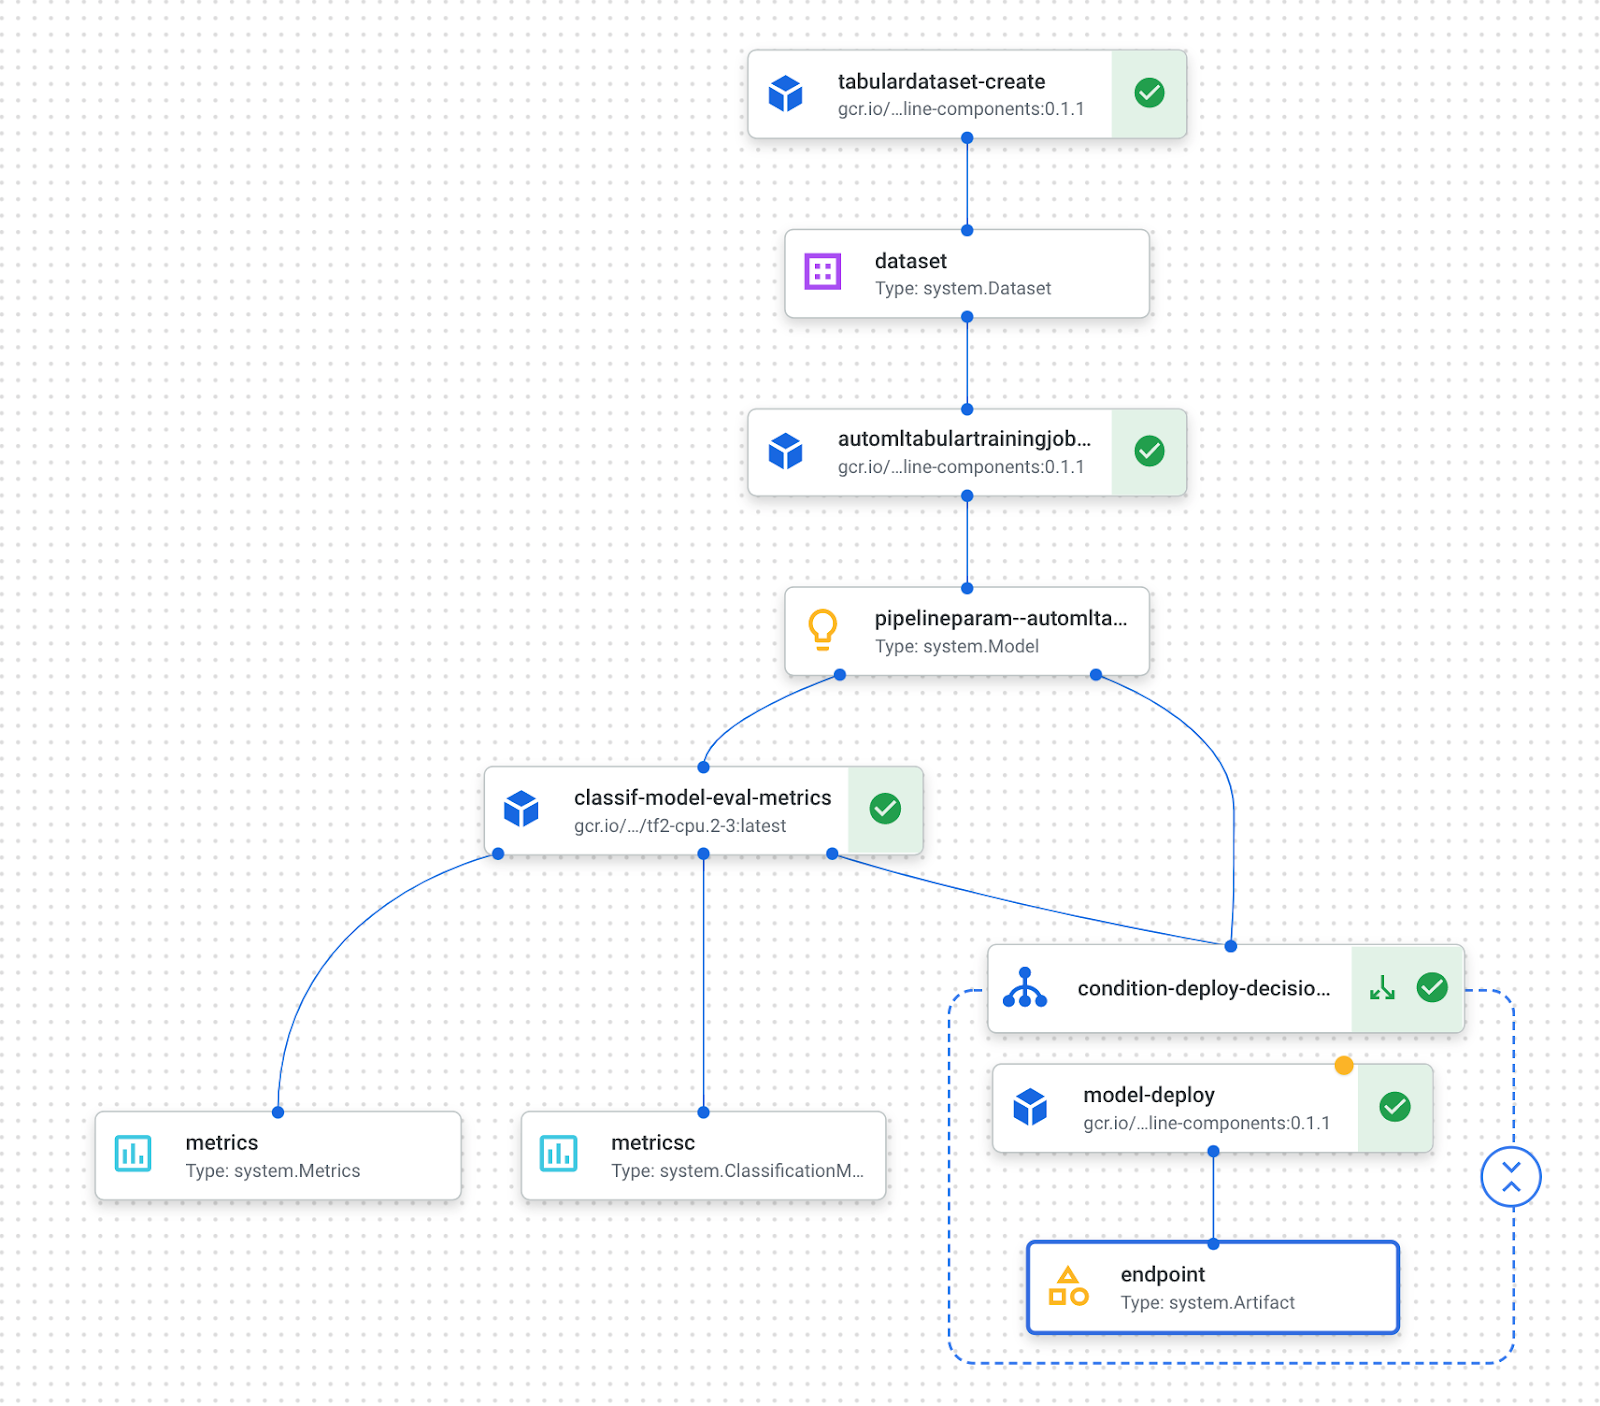

If you toggle the **Expand artifacts** button at the top, you'll be able to see details for the different artifacts created from your pipeline. For example, if you click on the dataset artifact, you'll see details on the Vertex AI dataset that was created. You can click the link here to go to the page for that dataset:

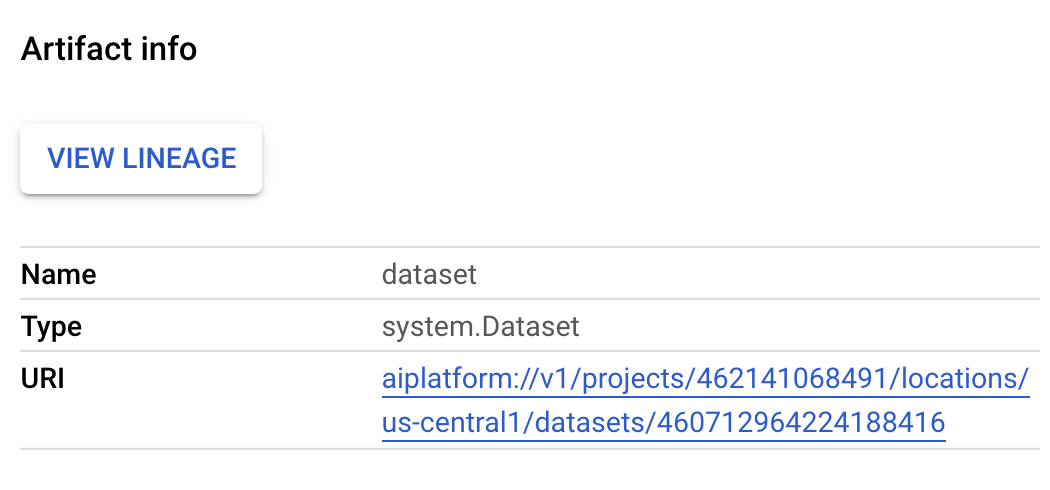

Similarly, to see the resulting metric visualizations from our custom evaluation component, click on the artifact called metricsc. On the right side of your dashboard, you'll be able to see the confusion matrix for this model:

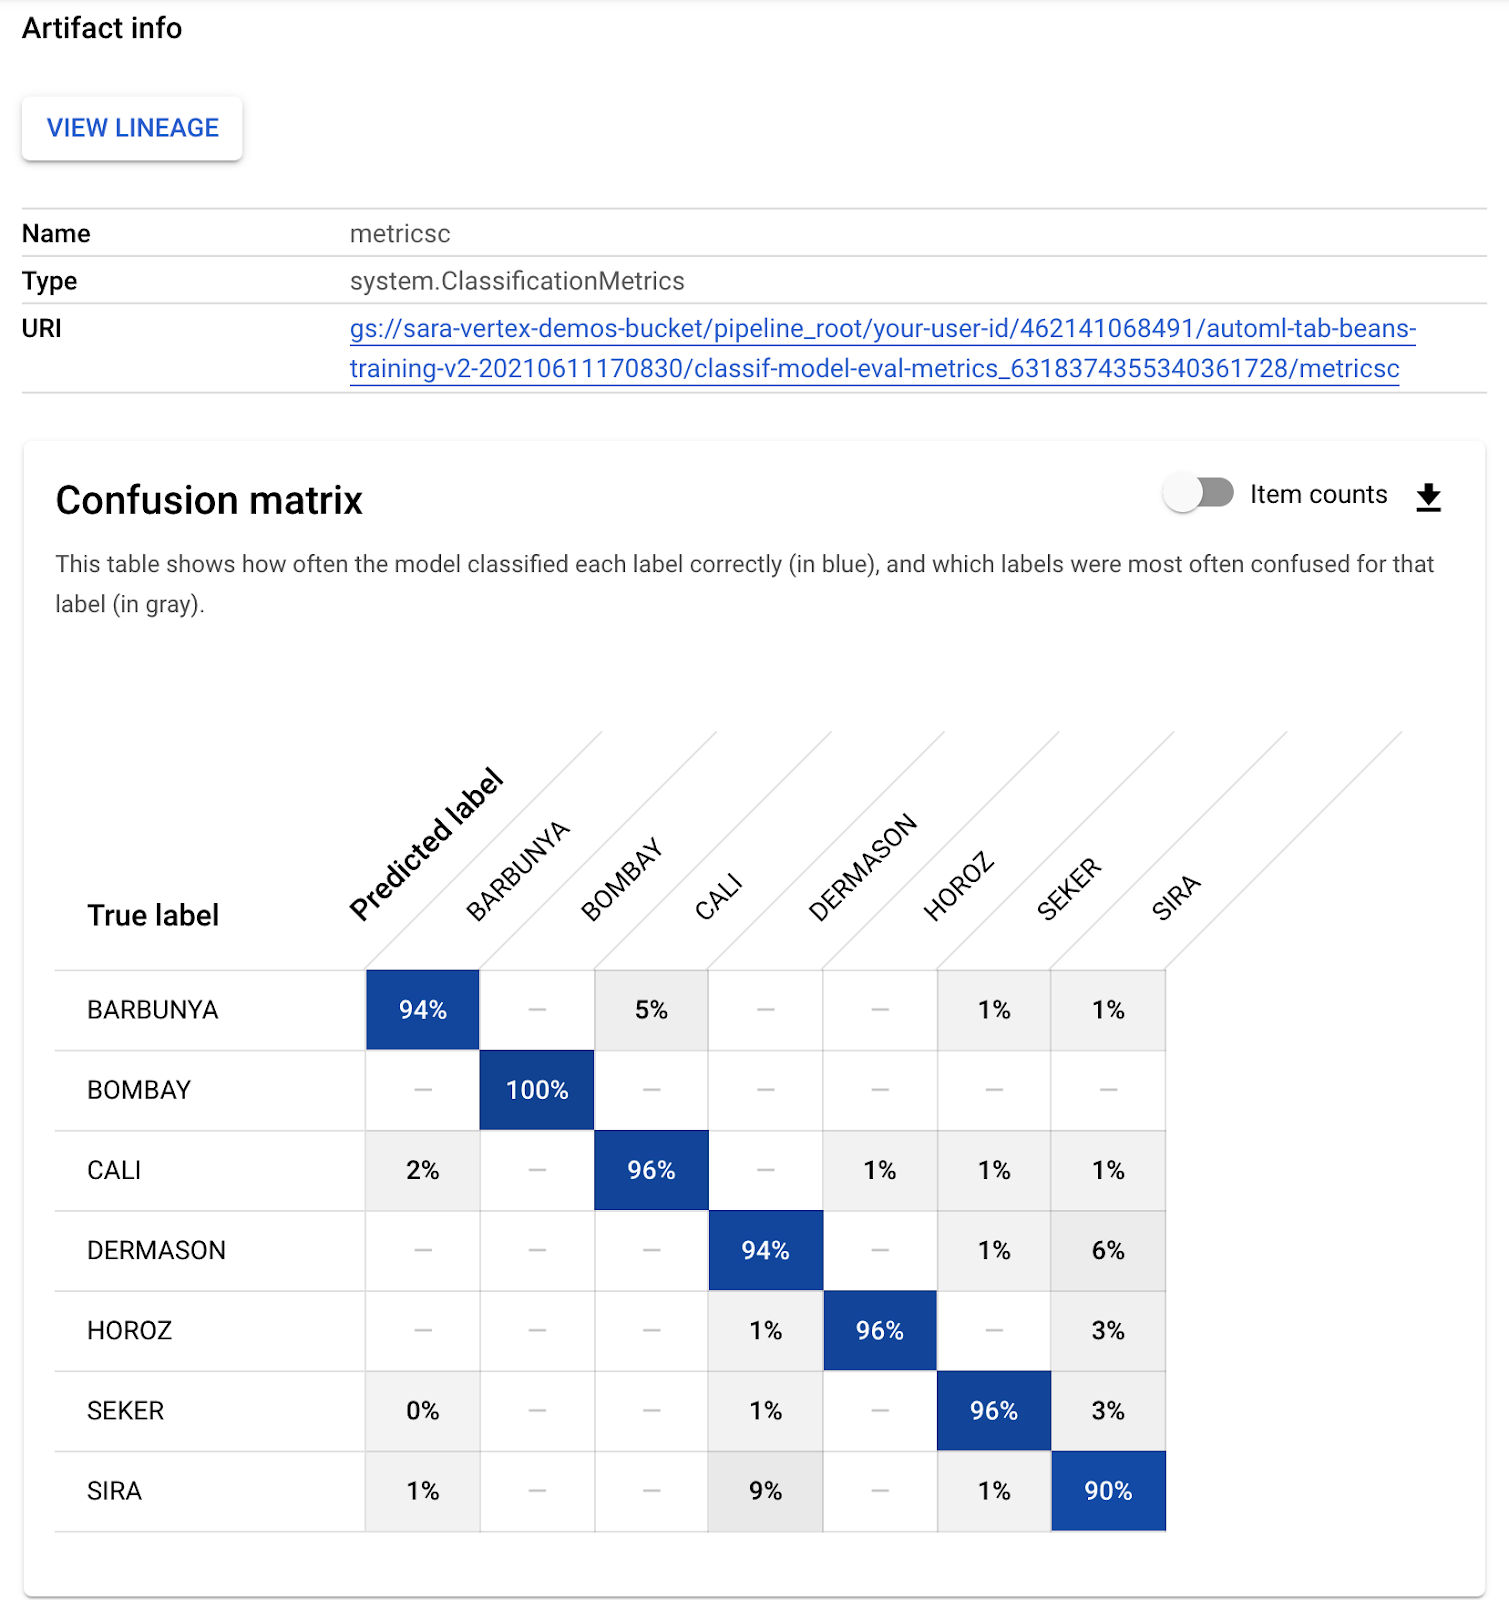

To see the model and endpoint created from this pipeline run, go to the models section and click on the model named automl-beans. There you should see this model deployed to an endpoint:

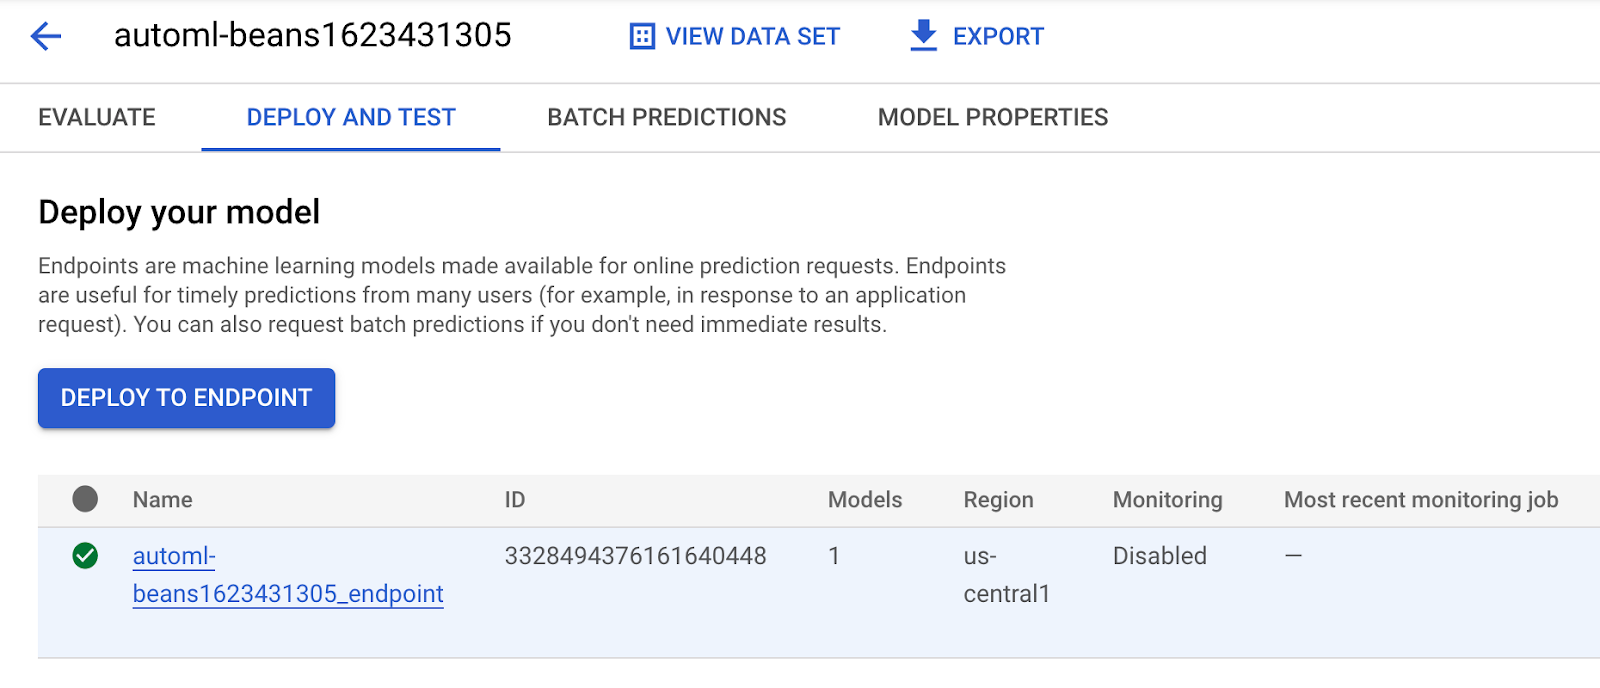

You can also access this page by clicking on the endpoint artifact in your pipeline graph.

In addition to looking at the pipeline graph in the console, you can also use Vertex Pipelines for Lineage Tracking. By lineage tracking, we mean tracking artifacts created throughout your pipeline. This can help us understand where artifacts were created and how they are being used throughout an ML workflow. For example, to see the lineage tracking for the **dataset** created in this pipeline, click on the dataset artifact and then **View Lineage**:

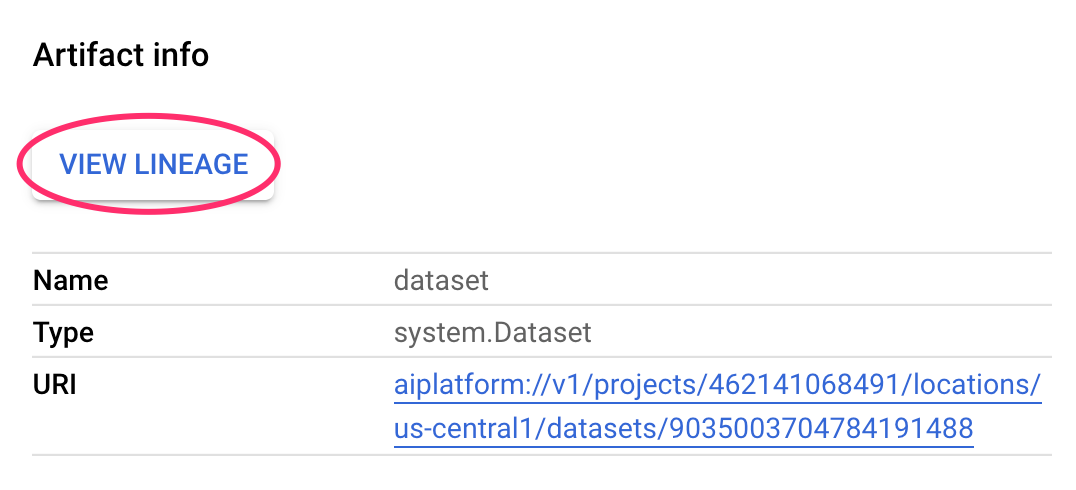

This shows us all the places this artifact is being used:

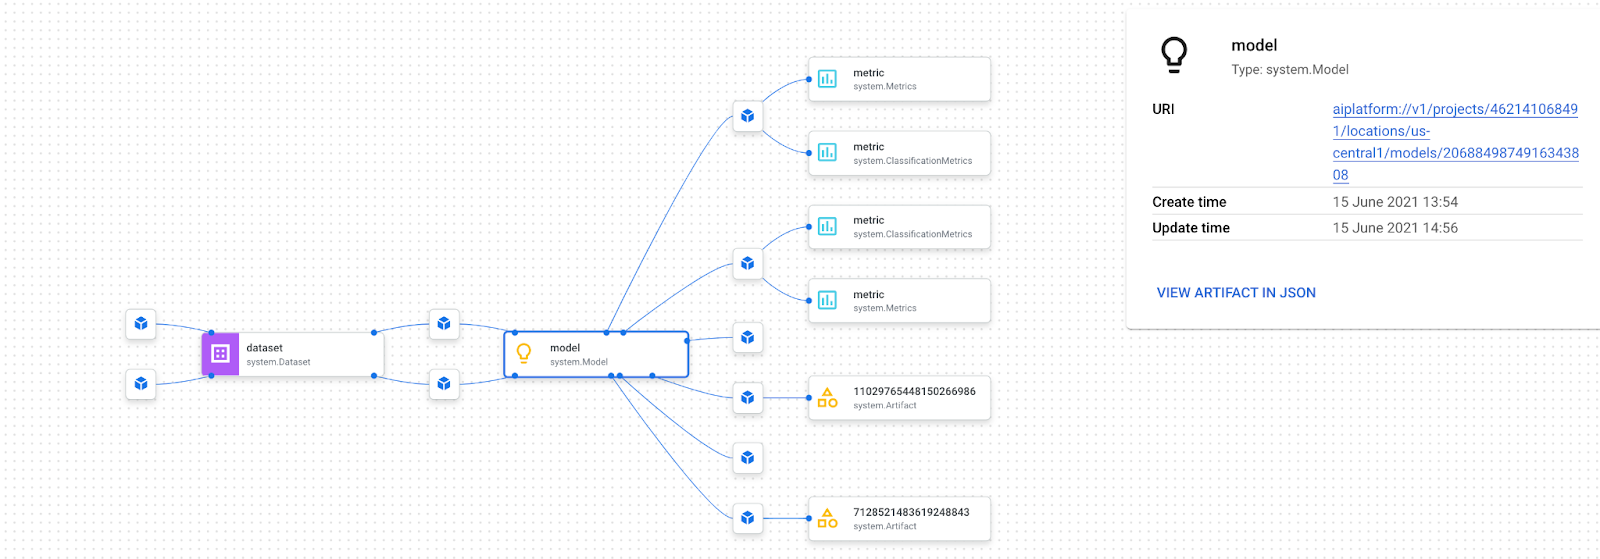

### Step 4: Comparing metrics across pipeline runs

If you run this pipeline multiple times, you may want to compare metrics across runs. You can use the aiplatform.get_pipeline_df() method to access run metadata. Here, we'll get metadata for all runs of this pipeline and load it into a Pandas DataFrame:




In [ ]:
pipeline_df = aiplatform.get_pipeline_df(pipeline="automl-tab-beans-training-v2")
small_pipeline_df = pipeline_df.head(2)
small_pipeline_df

You've now learned how to build, run, and get metadata for an end-to-end ML pipeline on Vertex Pipelines.

# Scheduling a recurring pipeline job (optional)

There are some scenarios where you may want to schedule a pipeline run for a specific time, or have a pipeline run at specific intervals. In this step you'll learn how to schedule pipeline runs using [Cloud Scheduler](https://cloud.google.com/scheduler).

This step is optional, so you can skip to the Cleanup step if you don't need to schedule pipeline runs.

We'll schedule the first 3-step pipeline we created here. Remember that when we compiled this pipeline we wrote it to a file called intro_pipeline_job.json. We'll use that file when we create the scheduled job.

Run the following to create a recurring scheduled job:

In [ ]:
response = api_client.create_schedule_from_job_spec(
    job_spec_path="intro_pipeline_job.json",
    schedule="2 * * * *",
    time_zone="America/Los_Angeles",  # change this as necessary
    parameter_values={"text":"Cloud Scheduler", "emoji_str": "100"},
    pipeline_root=PIPELINE_ROOT
)

Navigate to the [Scheduler section of your console](https://console.cloud.google.com/cloudscheduler) to see this job. It should look like this:


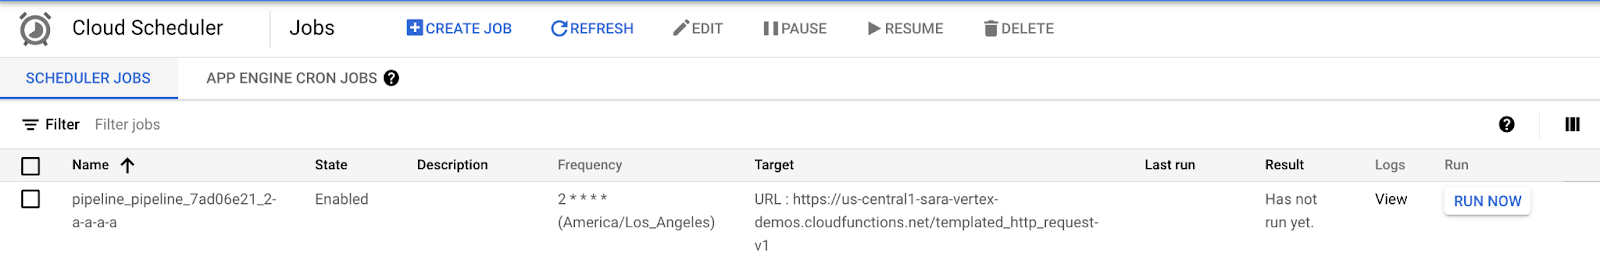

The 2 * * * * value we sent as the schedule parameter means this job will run hourly on the second minute of every hour: 9:02, 10:02, 11:02, etc. To run the pipeline now, click the Run now button in the console. For more details on configuration options for this, check out the [Scheduler docs here](https://cloud.google.com/scheduler/docs/configuring/cron-job-schedules?utm_source=codelabs&utm_medium=et&utm_campaign=CDR_sar_aiml_vertexio_&utm_content=-).

If you see an error about creating an App Engine app, you may need to do this for Cloud Scheduler to work. [Follow the steps here](https://cloud.google.com/scheduler/docs/quickstart?utm_source=codelabs&utm_medium=et&utm_campaign=CDR_sar_aiml_vertexio_&utm_content=-).

Important: make sure to **delete this scheduled job when you're done with this lab so that you're not charged for repeated pipeline runs**. Do this by checking the job and clicking delete, as shown here:

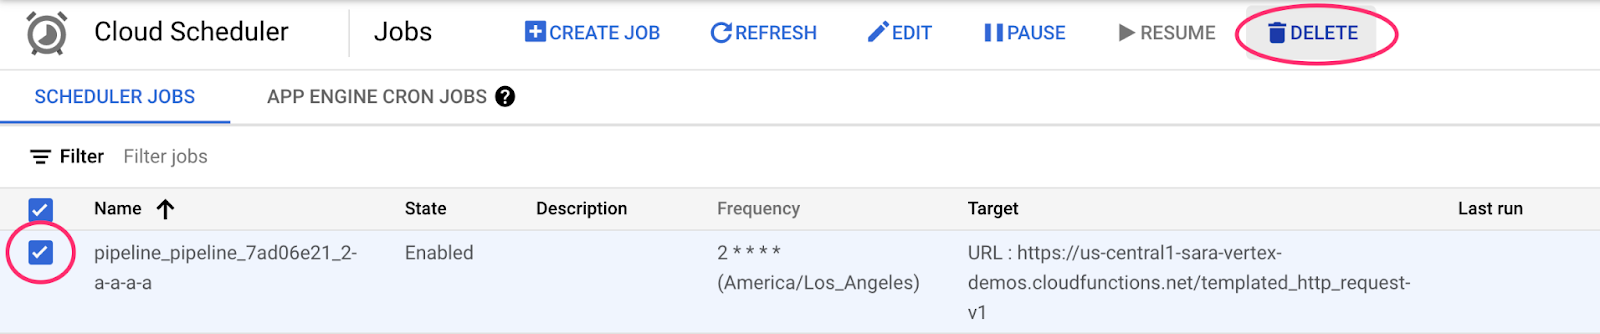

With that, you've finished the lab!

🎉 Congratulations! 🎉

You've learned how to use Vertex AI to:

* Use the Kubeflow Pipelines SDK to build end-to-end pipelines with custom components
* Run your pipelines on Vertex Pipelines and kick off pipeline runs with the SDK
* View and analyze your Vertex Pipelines graph in the console
* Use pre-built pipeline components to add Vertex AI services to your pipeline
* Schedule recurring pipeline jobs

To learn more about different parts of Vertex, check out the documentation.

# Cleanup

So that you're not charged, it is recommended that you delete the resources created throughout this lab.

### Step 1: Stop or delete your Notebooks instance

If you'd like to continue using the notebook you created in this lab, it is recommended that you turn it off when not in use. From the Notebooks UI in your Cloud Console, select the notebook and then select **Stop**. If you'd like to delete the instance entirely, select **Delete**:

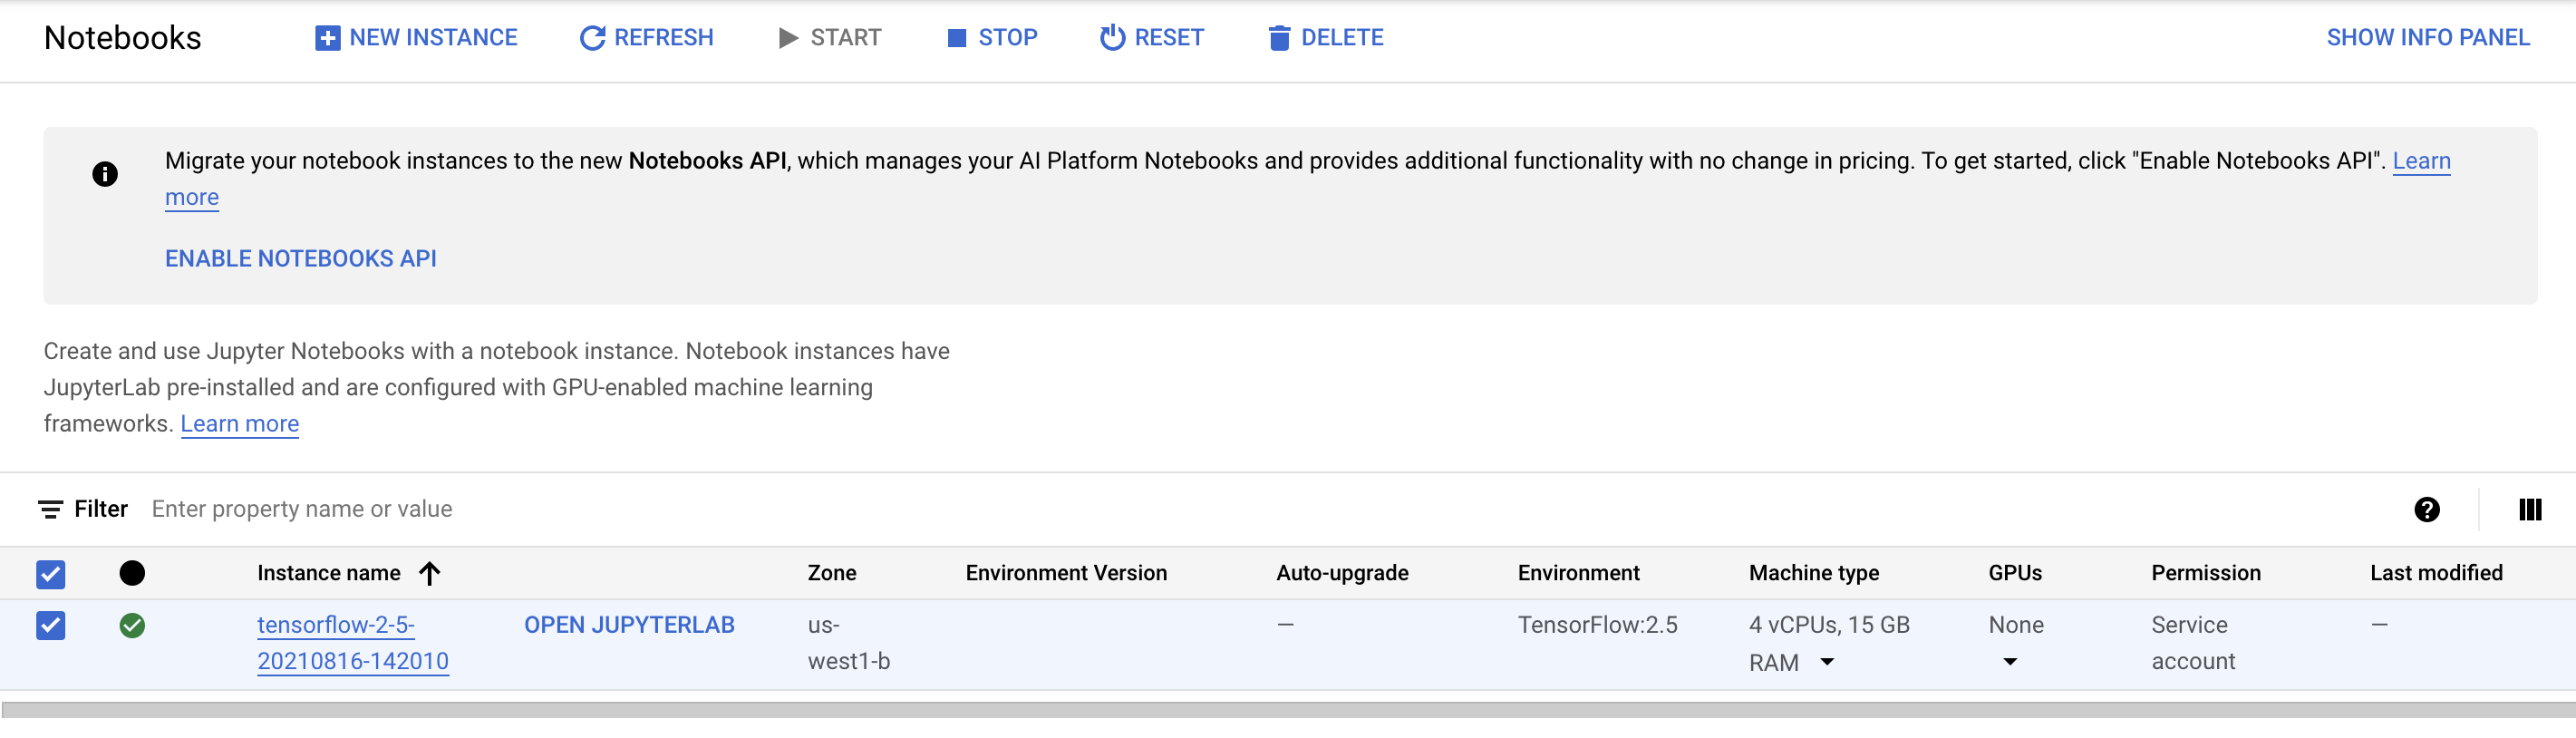

### Step 2: Delete your endpoint

To delete the endpoint you deployed, navigate to the **Endpoints** section of your Vertex AI console and click the **Delete** icon > **Undeploy**:

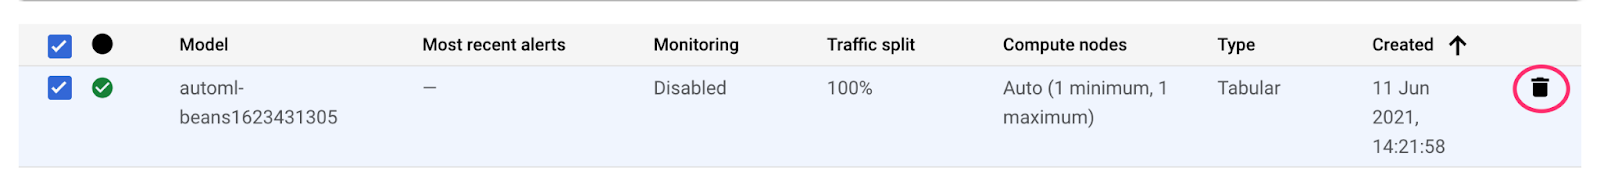

### Step 3: Delete your Cloud Storage bucket

To delete the Storage Bucket, using the Navigation menu in your Cloud Console, browse to **Cloud Storage**, select your bucket, and click **Delete**:

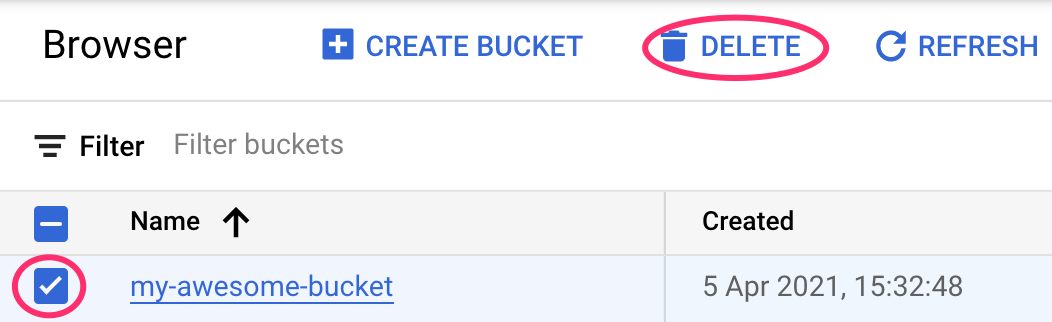

### Step 4: Delete your scheduled job

If you created a scheduled job in the previous step, you probably already deleted in but just in case you didn't, do that in the Scheduler section of your console:

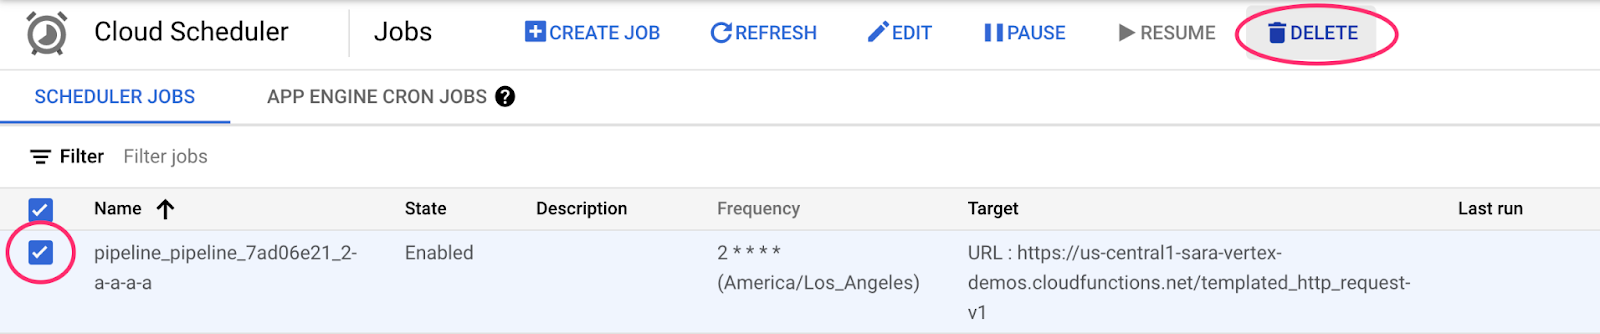